In [1]:
import pandas as pd
import re
import xlsxwriter
from vincent.colors import brews
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [2]:
url = 'https://github.com/Lirinawi/samples/blob/main/%D0%9D%D0%B0%D1%80%D1%83%D1%88%D0%B5%D0%BD%D0%B8%D1%8F%20%D1%81%D0%B5%D1%82%D0%B8%20%D0%BE%D1%82%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B8%CC%86.xlsx?raw=true'
df = pd.read_excel(url, sheet_name='авг-сен', 
                   usecols=['Отделение', 'Нарушение август', 'Отделение.1', 'Нарушение сентябрь'])
df.columns = ['Отделение предыдущего месяца', 'Нарушение предыдущего месяца', 'Отделение прошлого месяца', 'Нарушение прошлого месяца']
# удаление лишних пробелов
df[['Отделение предыдущего месяца', 'Отделение прошлого месяца']] = df[['Отделение предыдущего месяца', 
                                                                           'Отделение прошлого месяца']].applymap(lambda x: 
                                                                                       ' '.join(str(x).strip().split()))
df_previous = df[['Отделение предыдущего месяца', 'Нарушение предыдущего месяца']].copy()
df_previous.columns = ['Отделение', 'Нарушение']
df_last = df[['Отделение прошлого месяца', 'Нарушение прошлого месяца']].copy()
df_last.columns = ['Отделение', 'Нарушение']
# удаление пустых строк
df_last.dropna(inplace=True)
previous_month = input('Какой предыдущий месяц? ')
last_month = input('Какой прошлый месяц? ')

Какой предыдущий месяц? август
Какой прошлый месяц? сентябрь


In [3]:
url_rm = 'https://github.com/Lirinawi/samples/blob/main/%D0%9C%D0%B5%D0%BD%D0%B5%D0%B4%D0%B6%D0%B5%D1%80%D1%8B%20%D0%BE%D1%82%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B8%CC%86.xlsx?raw=true'
df_rm = pd.read_excel(url_rm, 
                      names = ['Отделение', 'заведующий', 'менеджер', 'старший менеджер'],
                      usecols=['Отделение', 'менеджер', 'старший менеджер'])
# удаление адреса отделения
df_rm['Отделение'] = df_rm['Отделение'].apply( lambda x: ''.join(re.findall(r'(\D+)(\d*)?\s?\(?.*\)?', x)[0]))

# также удаление адреса отделения, но используя функцию
# def rosdel(x_str):
#     '''
#     Функция для отсеивая части строки после числа
#     '''
#     a = []
#     for i in x_str.split():
#         a.append(i)
#         if i.isdigit():
#             break
#     return ' '.join(a)
# df_rm['Отделение'] = df_rm['Отделение'].apply(rosdel)

df_rm['менеджер'].fillna('нет руководителя', inplace=True)
df_rm['Отделение'] = df_rm['Отделение'].map(lambda x: ' '.join(str(x).strip().split()))
# оставляю только имя и фамилию
df_rm['менеджер'] = df_rm['менеджер'].map(lambda x: ' '.join(str(x).split()[:2]))

In [4]:
r_df_previous = df_previous.merge(df_rm, how='left', on='Отделение')
r_df_last = df_last.merge(df_rm, how='left', on='Отделение')

# поиск отделений, по которым не подтянулись менеджеры
r_df_previous_no_rm = list(r_df_previous.loc[r_df_previous['старший менеджер'].isna()]['Отделение'])
r_df_last_no_rm = list(r_df_last.loc[r_df_last['старший менеджер'].isna()]['Отделение'])
if r_df_previous_no_rm:
    print('К таблице за предыдущий месяц не подтянулись старший менеджер по отделениям: {}'.format(r_df_previous_no_rm))
if r_df_last_no_rm:
    print('К таблице за прошлый месяц не подтянулись старший менеджер по отделениям: {}'.format(r_df_last_no_rm))

К таблице за прошлый месяц не подтянулись старший менеджер по отделениям: ['Магазин 101', 'Магазин 102', 'Магазин 103']


In [5]:
# Построение сводных
pt_previous_rm = r_df_previous.pivot_table(index=['старший менеджер','менеджер'], columns='Нарушение', aggfunc='size')    #.fillna(0) 
pt_previous_srm = r_df_previous.pivot_table(index='старший менеджер', columns='Нарушение', aggfunc='size')         #.fillna(0)
pt_previous_srm['Месяц'] = previous_month
pt_previous_rm['Месяц'] = previous_month

pt_last_rm = r_df_last.pivot_table(index=['старший менеджер','менеджер'], columns='Нарушение', aggfunc='size')    #.fillna(0)
pt_last_srm = r_df_last.pivot_table(index='старший менеджер', columns='Нарушение', aggfunc='size')          #.fillna(0)
pt_last_srm['Месяц'] = last_month
pt_last_rm['Месяц'] = last_month

# Соединение сводных
pt_srm = pd.concat([pt_previous_srm, pt_last_srm]).sort_index().groupby(['старший менеджер', 'Месяц']).sum()
pt_rm = pd.concat([pt_previous_rm, pt_last_rm]).sort_index().groupby(['старший менеджер', 'менеджер', 'Месяц']).sum()

# Создание таблицы сравнения среднего количества нарушений на одно отделение
pt_srm_previous_sum = pt_srm.sum(axis=1).xs(previous_month, level=1)
pt_srm_last_sum = pt_srm.sum(axis=1).xs(last_month, level=1)
df_rm_cnt_otd = df_rm.groupby('старший менеджер').count()['Отделение']
pt_srm_sum = pd.concat([pt_srm_previous_sum, pt_srm_last_sum, df_rm_cnt_otd], axis=1)
pt_srm_sum.columns=[previous_month, last_month, 'к-во отделений']
pt_srm_sum['Ср. к-во нарушений, '+previous_month] = round(pt_srm_sum[previous_month]/pt_srm_sum['к-во отделений'], 2)
pt_srm_sum['Ср. к-во нарушений, '+last_month] = round(pt_srm_sum[last_month]/pt_srm_sum['к-во отделений'], 2)
pt_srm_sum_ = pt_srm_sum.iloc[:, 3:]

In [6]:
# удаление нулей из таблицы, чтобы на графику не было меток "0"
pt_rm.replace(0, None,inplace=True)
pt_srm.replace(0, None,inplace=True)
rm_dict = { 'Афанасий (Восток)': 'Восток','нет руководителя': 'Центр',
       'Захар (Запад)': 'Запад'}

def write_chart(df_, sheet_nm):
    '''
    Функция для вставки таблицы и графика на основе df_ на лист sheet_nm
    '''
    df_.to_excel(writer, sheet_name=sheet_nm)
    worksheet = writer.sheets[sheet_nm]
    chart = workbook.add_chart({ 'type' : 'column', 'subtype': 'stacked' })
    df_shape = df_.shape
    for col_num in range(2, df_shape[1] + 2):
            chart.add_series({
            'name': [sheet_nm, 0, col_num],
            'categories': [sheet_nm, 1, 0, df_shape[0], 1],
            'values': [sheet_nm, 1, col_num, df_shape[0], col_num],
            'fill': {'color': brews['Spectral'][col_num-2]},
            'data_labels': {'value': True, 'position': 'center'},
            'gap': 50,   #растояние между столбцами
            'font': 12   #размер шрифта
            })
    chart.set_title ({'name': 'Нарушения '+ sheet_nm, 'name_font': {'bold': True, 'font': 15}})
    chart.set_y_axis({'visible': False,
                          'major_gridlines': {'visible': False}})
    chart.set_size({'width': 990, 'height': 580})    #ширина и высота графика, в пикселях
    worksheet.insert_chart('B15', chart)   #ячейка, в которую будет вставлен график
    
def format_table(df_, sheet_nm, row_num, column_num):
    '''
    Функция для форматирования заголовка и ширины столбцов
    '''
    format_header = workbook.add_format({'text_wrap': True, 'align': 'center', 'valign': 'vcenter', 
                                        'fg_color': '#DAEEF3', 'bold': True, 'right': True})
#     запись заголовка с форматированием
    writer.sheets[sheet_nm].write_row(row_num, column_num, df_.reset_index().columns, format_header)
    for i, value in enumerate(df_.reset_index().columns.values):
#     Редактирование ширины столбцов  
        writer.sheets[sheet_nm].set_column(i,i, max(df_.reset_index()[value].astype(str).map(len).max()+2, 11))

In [7]:
with pd.ExcelWriter('report.xlsx', engine='xlsxwriter') as writer:
    workbook = writer.book
    
#     Создание листов с графиками по РМ
    for i in df_rm['старший менеджер'].unique():
        write_chart(pt_rm.loc[i], rm_dict[i])
        format_table(pt_rm.loc[i], rm_dict[i], 0, 0)
#     Создание листа с графиками по СРМ
    write_chart(pt_srm, 'старший менеджер')
    format_table(pt_srm, 'старший менеджер', 0, 0)
#     Создание листа с таблицами сравнения среднего количества нарушений на одно отделение
    pt_srm_sum_.to_excel(writer, sheet_name='ср.знач.')
    pt_srm_sum.to_excel(writer, sheet_name='ср.знач.', startrow=pt_srm_sum_.shape[0]+2)
    format_table(pt_srm_sum_, 'ср.знач.', 0, 0)
    format_table(pt_srm_sum, 'ср.знач.', pt_srm_sum.shape[0]+2, 0)
    

In [8]:
def create_chart(df_nm, chart_nm, meneger_level='менеджер'):
    '''
    Функция для создания графиков и сохрание их картинкой
    '''
    df_ = df_nm.copy()
    df_.dropna(axis=1, how='all', inplace=True)   
    df_.fillna(0, inplace=True)
        # скорачивание названий месяцов
    df_.reset_index(inplace=True)
#     сортировка при неверном порядке месяцов
    df_.sort_values(by='Месяц', ascending=False,inplace=True)
    df_['Месяц'] = df_['Месяц'].map(lambda x: x[:3])
    df_.set_index([meneger_level, 'Месяц'],inplace=True)

    fig, axes = plt.subplots(constrained_layout=False, figsize=(7,6), 
                             sharey=True) # оси y использовали одни и те же метки.
#     axes.set_title(chart_nm, fontsize=18, loc='center')
    axes.axis('off')  #убирает значение осей
    gs1 = fig.add_gridspec(nrows=1, ncols=len(df_.reset_index()[meneger_level].unique())
                           , left=0.02, right=1, wspace=0.1)
    color_dict=dict(zip(pt_rm.columns, brews['Spectral']))
    for n, i in enumerate(df_.reset_index()[meneger_level].unique()):
        f_ax0 = fig.add_subplot(gs1[n], 
                                ylim=[0,df_.sum(axis=1).max()+1], #область оси У
                                yticks=[], #удаление знаений на осях
                                frameon=False)  #удаленние черной рамки вокруг графика
        df_.xs(i, level=0).plot(kind='bar', stacked=True, color=color_dict, ax=f_ax0, rot=0,
                                width = 0.8)    # ширина столбцов
        f_ax0.legend().set_visible(False)
    #     добавление меток данных
    #   итерация по месяцам
        for month_n, month in enumerate(df_.reset_index()['Месяц'].unique()):
            cty_sum = 0
            #   итерация по категориям нарушений
            for j, cty in enumerate(df_.xs(i, level=0).loc[month]):
                if cty:
                    cty_sum += cty
                    f_ax0.text(month_n, cty_sum-cty/2, int(round(cty, 0)), horizontalalignment='center',
                              verticalalignment='center', fontsize=10)

        plt.xlabel('\n'.join(i.split()), loc='center', color='black')
    # добавления переноса длянного названия категории
    col_nm = list(df_.columns)
    if 'Некорректное заполнение заявки' in col_nm:
        col_nm[col_nm.index('Некорректное заполнение заявки')] = 'Некорректное заполнение\nзаявки'
    fig.legend(col_nm, 
               bbox_to_anchor=(1.53, 0.7), #положение легенды за рамкой графика
               fontsize=11,
               handlelength=2) # длина полоски цвета
    print(fig.dpi)
    # сохранение графика как картинки
    plt.savefig(chart_nm+'.png', bbox_inches='tight', dpi=504)

72.0
72.0
72.0
72.0


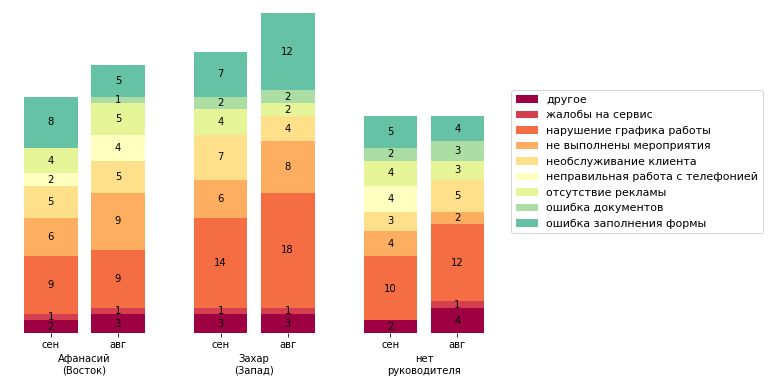

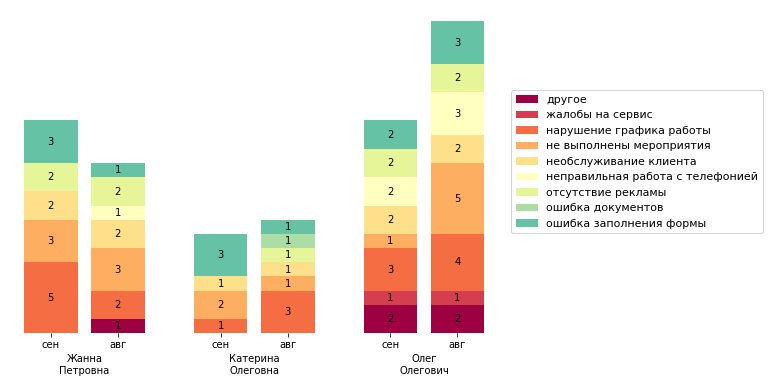

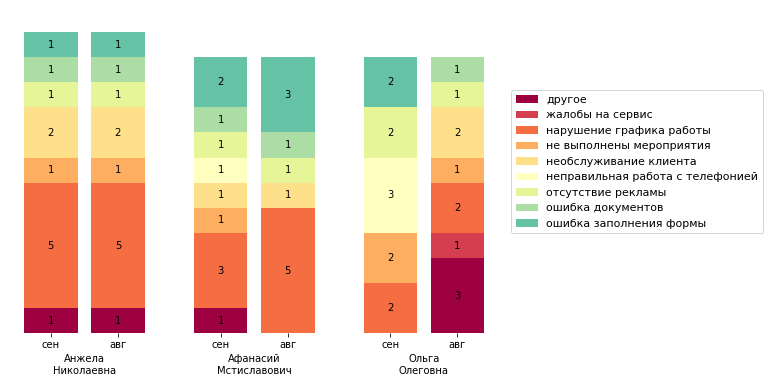

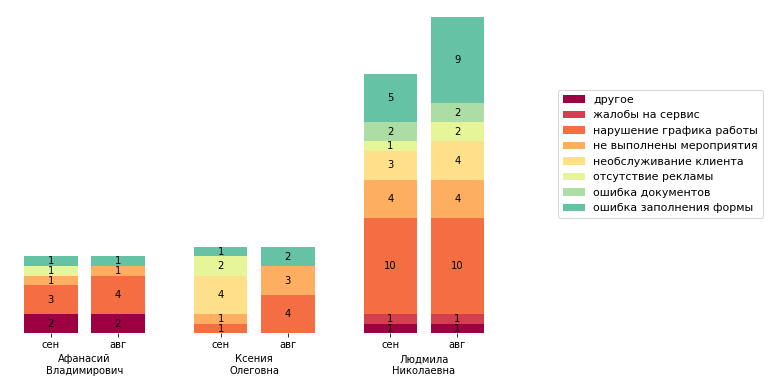

In [12]:
# запись графиков в виде изображений в презентацию

from pptx import Presentation
from pptx.util import Inches
from pptx.util import Pt

# create presentation with 1 slide ------
prs = Presentation()
slide = prs.slides.add_slide(prs.slide_layouts[5])
slide.shapes.title.text = "Нарушения по старшим менеджерам"
slide.shapes.title.size = Pt(14)
create_chart(pt_srm, "Нарушения по старшим менеджерам", 'старший менеджер')
slide.shapes.add_picture("Нарушения по старшим менеджерам"+'.png',
                      Inches(0), Inches(2),width =None ,height =None)
for i in df_rm['старший менеджер'].unique():
    create_chart(pt_rm.loc[i], "Нарушения "+rm_dict[i], 'менеджер') 
    slide = prs.slides.add_slide(prs.slide_layouts[5])
    slide.shapes.title.text = "Нарушения "+rm_dict[i]
    slide.shapes.add_picture("Нарушения "+rm_dict[i]+'.png',
                      Inches(0), Inches(2),width =None ,height =None)


prs.save('report.pptx')